### Installs the Required Dependencies


In [25]:
!pip install -U pandas
!pip install -U matplotlib
!pip install -U python-dotenv

!pip install nx-arangodb
!pip install arango-datasets

!pip install google-genai
!pip install langchain-openai
!pip install langchain-mistralai

!pip install langchain
!pip install langchain-google-genai
!pip install -U langchain-community
!pip install langgraph

!pip install python-louvain
!pip install tabulate


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip insta

### Imports the packages


In [1]:
# Import required modules
import json
import os
from pydantic import BaseModel, Field
from typing import Optional, List, Dict, Tuple, Literal, Union, Any
from typing_extensions import Annotated, TypedDict
from enum import Enum
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tabulate import tabulate
import pprint
import re
import shutil



import networkx as nx
import nx_arangodb as nxadb
from pathlib import Path  
from dotenv import load_dotenv


from arango import ArangoClient
from arango_datasets import Datasets
from langchain.chat_models import init_chat_model
from langchain.prompts import PromptTemplate
from langchain.graphs import ArangoGraph
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_openai import ChatOpenAI
from langchain_mistralai import ChatMistralAI
from langchain.chains import ArangoGraphQAChain
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate
from langchain.memory import ConversationBufferMemory
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import HumanMessage
from langchain.tools import tool
from langchain.chains import ArangoGraphQAChain
import community as community_louvain 




# Gemini SDK Packages
from google import genai

# OpenAI SDK Packages
from openai import OpenAI

[16:34:07 -0800] [INFO]: NetworkX-cuGraph is unavailable: No module named 'cupy'.


### Loads the env variables


In [2]:

load_dotenv()


ARANGO_HOST = os.environ["ARANGO_HOST"]
ARANGO_PASSWORD = os.environ["ARANGO_PASSWORD"]
ARANGO_USERNAME = os.environ["ARANGO_USERNAME"]
GEMINI_API = os.environ["GEMINI_API_KEY"]
OPENAI_API_KEY = os.environ["OPEN_API_KEY"]
MISTRAL_API_KEY = os.environ["MISTRAL_API_KEY"]
LANGSMITH_TRACING=os.environ["LANGSMITH_TRACING"]
LANGSMITH_ENDPOINT=os.environ["LANGSMITH_ENDPOINT"]
LANGSMITH_API_KEY=os.environ["LANGSMITH_API_KEY"]
LANGSMITH_PROJECT=os.environ["LANGSMITH_PROJECT"]

### Initialize the ArangoDB Connection, LLM Instance, and initializing the constants


##### ArangoDB Connection


In [3]:
arango_client = ArangoClient(hosts=ARANGO_HOST).db(username=ARANGO_USERNAME, password=ARANGO_PASSWORD, verify=True)

#### Gemini and OpenAI SDK Instance


In [4]:
gemini_client = genai.Client(
    api_key=GEMINI_API
)

openai_client = OpenAI(
    api_key=OPENAI_API_KEY
)

#### Model Names' Constants


In [5]:
# Gemini models
GEMINI_FLASH_MODEL = "gemini-2.0-flash"
GEMINI_FLASH_LITE_MODEL = "gemini-2.0-flash-lite"
GEMINI_PRO_MODEL = "gemini-1.5-pro"

# OpenAI Model
GPT_4O = "gpt-4o-2024-08-06"


# MistralAI Model
MISTRAL_LARGE="mistral-large-latest"


### Conditionally loads the SYNTHEA_P100 dataset in ArangoDB and creates an ArangoGraph instance using ArangoDB instance


#### Loads the dataset in ArangoDB


In [6]:
datasets = Datasets(arango_client)

DATASET_NAME = "SYNTHEA_P100"

# Conditionally Loads the Synthea P100 dataset in Arango
if not arango_client.has_graph(DATASET_NAME):
  datasets.load(dataset_name=DATASET_NAME)
else:
  print(f"{DATASET_NAME} is already in ArangoDB.")

/Users/gurneeshbudhiraja/Developer/arango-hackathon/lib/python3.11/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

SYNTHEA_P100 is already in ArangoDB.


#### Creates an ArangoGraph instance using the Arango DB instance


In [7]:
# Connects with the Graph in ArangoDB
graph = None
if arango_client.has_graph(DATASET_NAME):
  graph = nxadb.Graph(name="SYNTHEA_P100",db=arango_client)
else:
  print("Graph does not exist in Arango DB")

print(graph)

[16:34:10 -0800] [INFO]: Graph 'SYNTHEA_P100' exists.
[16:34:10 -0800] [INFO]: Default node type set to 'allergies'


Graph named 'SYNTHEA_P100' with 145514 nodes and 311701 edges


#### Graph Schema


In [8]:
arango_graph = ArangoGraph(db=arango_client)

#### Graph Plot


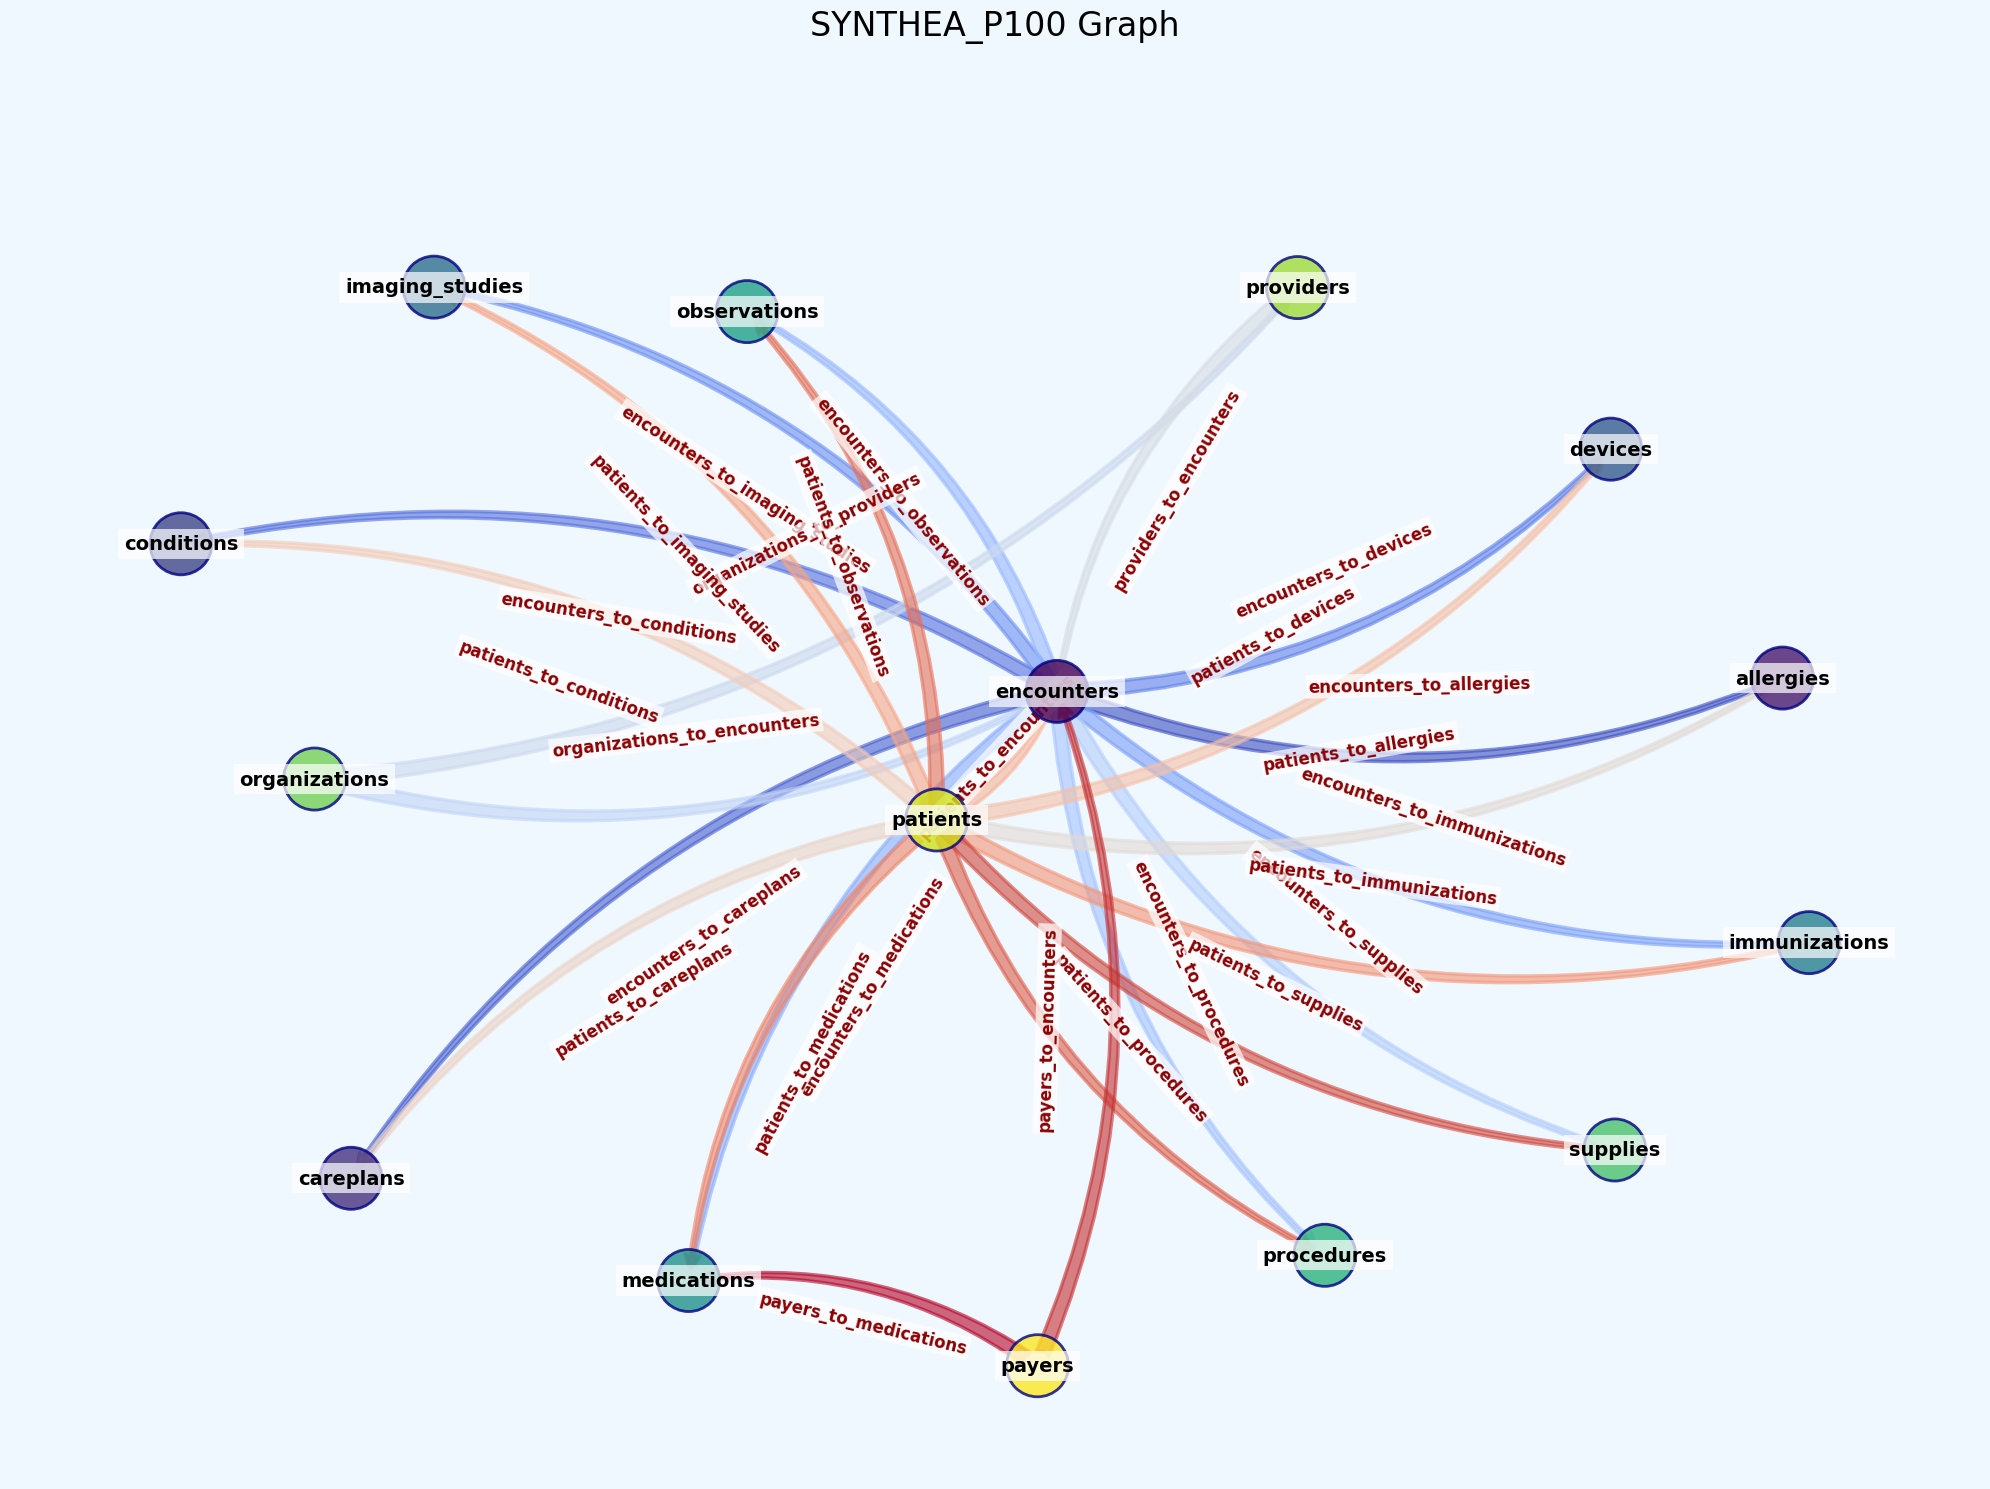

In [9]:
# Extract graph schema and edge definitions from schema data
graph_schema = arango_graph.schema["Graph Schema"][0]
edge_definitions = graph_schema["edge_definitions"]


# Create directed graph and add edges based on vertex collections
G_schema = nx.DiGraph()
for ed in edge_definitions:
    edge_collection = ed["edge_collection"]
    from_list = ed["from_vertex_collections"]
    to_list = ed["to_vertex_collections"]
    for f in from_list:
        for t in to_list:
            G_schema.add_edge(f, t, label=edge_collection)


# Set the layout for the graph visualization
pos = nx.spring_layout(G_schema, k=2, seed=42)


# Create figure with light blue background
plt.figure(figsize=(20, 15), facecolor='#f0f8ff')


# Draw nodes with color gradient
node_colors = plt.cm.viridis(np.linspace(0, 1, len(G_schema.nodes())))
nx.draw_networkx_nodes(
    G_schema, pos,
    node_size=2000,
    node_color=node_colors,
    edgecolors='navy',
    linewidths=2.0,
    alpha=0.8
)


# Draw edges with color gradient and curved arrows
edge_colors = plt.cm.coolwarm(np.linspace(0, 1, len(G_schema.edges())))
nx.draw_networkx_edges(
    G_schema, pos,
    arrowstyle='fancy',
    arrowsize=25,
    edge_color=edge_colors,
    width=2.5,
    connectionstyle='arc3,rad=0.2',
    alpha=0.6
)


# Add node labels with white background
nx.draw_networkx_labels(
    G_schema, pos,
    font_size=14,
    font_weight='bold',
    bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=4)
)


# Add edge labels with white background
edge_labels = nx.get_edge_attributes(G_schema, 'label')
nx.draw_networkx_edge_labels(
    G_schema, pos,
    edge_labels=edge_labels,
    font_color='darkred',
    font_size=12,
    font_weight='bold',
    bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=2)
)

plt.title("SYNTHEA_P100 Graph", fontsize=24, pad=100)
plt.axis("off")
plt.tight_layout()


plt.grid(True, linestyle='--', alpha=0.5)

plt.show()



### Helper Functions


In [15]:
def print_table_message(text_list:List[str], headers: List[str] = [], tablefmt: str = "orgtbl")->None:
  """
  Prints a formatted message in a table format using tabulate library
  Parameters:
    text_list: List of strings to be displayed in the table
    headers: Optional list of column headers
    tablefmt: Table format style (default is "orgtbl")
  """
  print(tabulate([text_list],headers=headers,tablefmt=tablefmt))


def print_agent_tool(tool_name:str):
  # Get the terminal's width
  terminal_width = shutil.get_terminal_size().columns

  # Center the tool name and print it
  centered_message = f"{'🩺 Using Tool: text_to_nx_algorithm_to_text'.center(terminal_width)}"
  print(centered_message)


### AQL Agent


In [351]:
def aql_agent(user_query:str):
  # LLM
  aql_llm = ChatGoogleGenerativeAI(
    model=GEMINI_FLASH_LITE_MODEL,
    api_key=GEMINI_API,
    temperature=0.2,
  )

  print("\n")
  print_table_message(
    text_list=["🚀 Running the ArangoGraphQAChain"]
  )
  chain = ArangoGraphQAChain.from_llm(
    llm=aql_llm, 
    graph=arango_graph, 
    verbose=True,
    allow_dangerous_requests=True,
    )

  aql_chain_response = chain.invoke([HumanMessage(content=user_query)])
  return aql_chain_response


### Degree Centrality Agent


#### Gloabal Variables(for degree centrality agent only)


In [352]:
dc_G = None
top_n_sorted_centrality = None

#### Schema


In [353]:
class DC_QueryParserSchema(BaseModel):
  entity_type: str = Field(default="", description="Entity type to query (e.g., patients)")
  top_n: int = Field(default=5, description="Number of top results to return")
  relationship: str = Field(default="direct relationships", description="Type of relationships to consider")

class DC_QueryGenerator(BaseModel):
  aql_query: str = Field(default="", description="AQL query to execute")


class Dc_GetGraphSchema(BaseModel):
  node_id: str = Field(default=None, description="Node id to plot the graph of. If nothing has been mentioned about the node_id select the id with the highest score or return None")
  num_neighbors: int = Field(default=10, description="Number of neighbors to include in the graph.")
  message: str = Field(default="", description="This is the message that will be shown to the user about the type of graph you are plotting Make sure this message is complete and gives the idea to the user for which node id and number of neighbors the graph is being plotted for. Keep it as verbose as possible for the end user.")
  

#### Tools


In [354]:
# dc = Degree Centrality

@tool
def dc_query_parser(user_query:str):
  """
  The function takes in the initial user query and returns a dictionary containing the entity_type, top_n, and graph relationship

  Args: 
    user_query: str = Query asked by the user.
  
  Returns:
    {
        "entity_type": str,
        "top_n": int,
        "graph": str
    }
  """
  print("\n-------------------- Using the dc_query_parser Tool --------------------")
  query_output_parser = JsonOutputParser(pydantic_object=DC_QueryParserSchema)

  prompt = PromptTemplate(
      template="""You are a helpful assistant that parses the user query to extract the entity_type, top_n, and graph relationship. Follow these instructions for giving the output: {format_instructions}. This is the user query asked by the user: {user_query}""",
      input_variables=["user_query"],
      partial_variables={"format_instructions": query_output_parser.get_format_instructions()}
  )

  llm = ChatGoogleGenerativeAI(
    model=GEMINI_PRO_MODEL,
    api_key=GEMINI_API,
    temperature=0
  )

  chain = prompt | llm | query_output_parser
  response = chain.invoke({"user_query": user_query})
  print("-------------------- START RESPONSE: dc_query_parser Tool Response --------------------")
  print(response)
  print("-------------------- END RESPONSE: dc_query_parser Tool Response --------------------")
  return response

@tool
def dc_aql_query_generator(entity_type:str, relationship:str):
  """
  The tool is used to generate and return the dictionary containing AQL queries for the graph generation.

  Args:
    entity_type: str = The type of entity to be queried.
    relationship: str = The graph relationship to be queried.

  Returns:
    The dict containing keys 'node_query' and 'edge_queries'
  """
  
  print("\n-------------------- Using the dc_query_generator Tool --------------------")

  # parser
  dc_query_parser = JsonOutputParser(pydantic_object=DC_QueryParserSchema)

  prompt = PromptTemplate(
    template="""
      You are given an ArangoDB graph with a node collection and several edge collections. The node collection is named "{entity_type}" and you should consider edges representing "{relationship}". 

      Generate a JSON object with two keys:
      - "node_query": an AQL query that retrieves all documents from the node collection "{entity_type}". For example:
        FOR doc IN {entity_type}
            RETURN doc
      - "edge_queries": a JSON object mapping each of the following edge collections to an AQL query that retrieves all its documents:
          - patients_to_allergies
          - patients_to_careplans
          - patients_to_conditions
          - patients_to_devices
          - patients_to_encounters
          - patients_to_imaging_studies
          - patients_to_immunizations
          - patients_to_medications
          - patients_to_observations
          - patients_to_procedures
          - patients_to_supplies

      For each edge collection, the query should be in the format:
        FOR edge IN <edge_collection>
            RETURN edge

      Return the final result as a JSON object with the keys "node_query" and "edge_queries". Follow these instructions while generating the output: {format_instructions}
  """,
    input_variables=["entity_type","relationship"],
    partial_variables={"format_instructions": dc_query_parser.get_format_instructions()}
  )
  
  
  aql_llm = ChatGoogleGenerativeAI(
    model=GEMINI_FLASH_MODEL,
    api_key=GEMINI_API,
    temperature=0.2
  )
  chain = prompt | aql_llm | dc_query_parser
  chain_response = chain.invoke({
    "entity_type": entity_type,
    "relationship": relationship
  })
  return chain_response


@tool
def dc_graph_builder(node_query:str, edge_queries:Dict[str,str]):
  """
  The tool is used to build the graph using the node query and edge queries.

  Args:
    node_query: str = The node query
    edge_queries: Dict[str, str] = The dictionary containing the edge_queries
  Returns:
    None: The function assigns that graph instance to the global variable.
  """

  print("\n-------------------- Using the graph_builder Tool --------------------")
  # Get the global graph instance
  global dc_G


  nodes_cursor = arango_client.aql.execute(node_query)
  nodes = list(nodes_cursor) 

  # Initialize an empty graph
  dc_G = nx.Graph()

  for node in nodes:
    dc_G.add_node(node['_id'])


  for _, query in edge_queries.items():
    edges_cursor = arango_client.aql.execute(query)
    for edge in edges_cursor:
      source = edge["_from"].split("/")[-1]
      target = edge["_to"].split("/")[-1]
      
      # Optionally ensures that both nodes exist before adding an edge:
      if source not in dc_G.nodes():
          dc_G.add_node(source)
      if target not in dc_G.nodes():
          dc_G.add_node(target)
      
      dc_G.add_edge(source, target)
  
  print("-------------------- Graph built successfully! --------------------")
  print(f"Number of nodes in the graph:\n{dc_G.number_of_nodes()}")
  print(f"Number of edges in the graph:\n{dc_G.number_of_edges()}")
  print("\n")

@tool
def dc_calculate_degree_centrality(top_n: int, entity_type:str):
  """
  The tool is used to calculate the degree centrality of the graph.

  Args:
    top_n: int = The number of top entities to be queried.
    entity_type: str = The type of entity to be queried.

  Returns:
    The degree centrality results of the top_n entity types
  """

  print("\n-------------------- Using the calculate_degree_centrality Tool --------------------")

  # Gets the global graph instance
  global dc_G, top_n_sorted_centrality 
  degree_centrality = nx.degree_centrality(dc_G)

  
  sorted_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
  top_n_sorted_centrality = sorted_centrality[:top_n]
  
  print("-------------------- START: calculate_degree_centrality Tool response --------------------")
  
  print(f"Top {top_n} most connected {entity_type} based on degree centrality:")
  
  for entity, centrality in top_n_sorted_centrality:
      print(f"Condition ID: {entity}, Degree Centrality: {centrality:.4f}")
  
  print("-------------------- END: calculate_degree_centrality Tool response --------------------")
  print("\n")
  return top_n_sorted_centrality




#### DC Caller Function


In [355]:
def degree_centrality_agent(user_query:str):
  """
  The degree centrality agent to handle the degree centrality related queries.
  """
  tools = [dc_query_parser, dc_aql_query_generator,dc_graph_builder,dc_calculate_degree_centrality]

  # model = init_chat_model(
  #   model=MISTRAL_LARGE,
  #   api_key= MISTRAL_API_KEY,
  #   model_provider="mistralai"
  # )
  model = init_chat_model(
    model=GPT_4O,
    api_key= OPENAI_API_KEY,
    model_provider="openai"
  )
  agent_executor = create_react_agent(
    model=model,
    tools=tools,
    prompt="""
      You are the Degree Centrality agent whose main aim is to find the degree centrality using the given tools. For every user query, always use the below mentioned tools in the same sequence they are mentioned in:
        1. dc_query_parser: This tool would help extract the 'entity_type', value of 'top_n' and 'relationship' from the user query which is important for the next tools.

        2. dc_aql_query_generator: This tool is responsible to generate 'node_query' and 'edge_queries' using the 'entity_type' and 'relationship' fetched from the previous tool.
        
        3. dc_graph_builder: This tool will use the 'node_query' and 'edge_queries' generated from the previous tool to build the graph and returns nothing as it assigns the graph it built to the global variable.

        4. dc_calculate_degree_centrality: This is the final tool that will calculate the degree centrality using the global graph variable and accepts the 'top_n' and 'entity_type' that is fetched from the 'dc_query_parser' tool. It returns the information containing the degree centrality information. Please make sure to run this tool at the end of the chain.

        5. dc_plot_visualisation: Use this tool when the user has asked for some kind of visualization in the initial user query.

      At the end, use the data from the `dc_plot_visualisation` tool to reply the user in the natural language. And the end reponse should only contain what the user has asked and should not contain any open ended questions.

      Do not add open ended questions in your final response.
    """
  )
  
  dc_agent_response = agent_executor.invoke({"messages":[HumanMessage(content=user_query)] })
  return dc_agent_response

#### DC Helper Functions


In [ ]:

# NOT A TOOL : This is the helper function that plots degree centrality graphs
def dc_plot(node_id:str=None, num_neighbors:int=10):
    """
    Creates the visualisation using the node_id and num_neighbors. If no node_id has been given, the function gets the node_id having the highest degree centrality. Also, the default value of the num_neighbors is 10.
    
    Args:
        node_id: str = The node ID to highlight. If None, the node with the highest degree centrality is used. It has the default value of None.
        num_neighbors: int =  Number of neighbors to include in the subgraph. It has the default value of 10
    
    Returns:
      None as this tool helps visualise based on the data.
    """
    print(node_id)
    print(num_neighbors)
    
    global dc_G

    # Copy global graph
    G = dc_G.copy()

    # Choose the highest degree centrality node when no node is provided
    if node_id is None:
        degree_centrality = nx.degree_centrality(G)
        node_id, _ = max(degree_centrality.items(), key=lambda x: x[1])
    
    # Gets a limited number of neighbors
    neighbors = list(G.neighbors(node_id))[:num_neighbors]
    subgraph_nodes = [node_id] + neighbors
    subG = G.subgraph(subgraph_nodes)
    
    # Set up the figure with a light background
    plt.style.use('default')
    plt.figure(figsize=(12, 12), facecolor='white')
    plt.gca().set_facecolor('white')
    
    # Use a spring layout for a visually appealing arrangement
    sub_pos = nx.spring_layout(subG, k=0.8)
    
    # Prepare a colormap for edges
    edges = list(subG.edges())
    cmap = cm.get_cmap('viridis', len(edges))
    edge_colors = [cmap(i) for i in range(len(edges))]
    
    # Draw each edge individually with its assigned color
    for idx, edge in enumerate(edges):
        nx.draw_networkx_edges(subG, sub_pos, edgelist=[edge], width=1.2, edge_color=[edge_colors[idx]], alpha=0.8)
    
    # Draw all nodes in a modern blue with a white border
    nx.draw_networkx_nodes(subG, sub_pos, 
                          node_size=300,
                          node_color='#4A90E2',
                          alpha=0.9,
                          edgecolors='white',
                          linewidths=0.5)
    
    # Highlight the central node with a contrasting red color and larger size
    nx.draw_networkx_nodes(subG, sub_pos,
                          nodelist=[node_id],
                          node_size=500,
                          node_color='#FF6B6B',
                          alpha=1,
                          edgecolors='black',
                          linewidths=1)
    
    # Add labels for visibility
    nx.draw_networkx_labels(subG, sub_pos,
                            font_size=8,
                            font_color='black',
                            font_weight='light')
    
    plt.title("Degree Centrality Plot", fontsize=16, color='black', pad=20, fontweight='bold')
    plt.axis("off")
    plt.tight_layout()
    plt.show()


# NOT A TOOL : This is to verify the degree centrality results for the user
def dc_verify(top_n:int = 5):
  """
    Verifies the degree centrality results by comparing the computed centrality
    with the expected value (degree / (total_nodes - 1)) and prints an ASCII table.

    Args:
      top_n (int): Number of top nodes to display.
  """
  # Gets the global graph instance
  global dc_G

  # Copies the global Graph instance
  G = dc_G.copy()
  degree_centrality = nx.degree_centrality(G)
  total_nodes = G.number_of_nodes()
  
  # Sort nodes by degree centrality in descending order and extract top_n
  sorted_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
  top_results = sorted_centrality[:top_n]
  
  # Prepare table rows
  table = []
  for node, centrality in top_results:
      degree = G.degree(node)
      expected = degree / (total_nodes - 1)
      table.append([node, degree, f"{expected:.4f}", f"{centrality:.4f}"])
  
  # Headers for the table
  headers = ["Node ID", "Degree", "Expected Centrality", "Computed Centrality"]
  
  # Print the table using tabulate
  print("\n======================= Verification of the Degree Centrality Agent =======================")
  print(tabulate(table, headers=headers, tablefmt="grid"))
  print("\n\n")



# Plot the graph based on the user query and degree centrality agent response
def dc_get_graph(user_query:str, dc_agent_response:str) -> None:
  """
    Uses the LLM to get the node_id and num_neighbors from the user query to pass to the dc_plot
  """
  dc_get_graph_llm = ChatMistralAI(
    model=MISTRAL_LARGE,
    api_key=MISTRAL_API_KEY,
    temperature=0.0
  )
  dc_get_graph_parser = JsonOutputParser(pydantic_object=Dc_GetGraphSchema)
  dc_get_graph_prompt = PromptTemplate(
    template="""
      You are a helpful agent that extracts key instructions from a user query. Your task is to determine:
        1. Which node id to use based on the user's instructions.
        2. The number of neighbors to use when plotting the graph.

      Please consider that the user query may be incomplete so take a pause to think and decide which node id to select from the degree centrality agent response based on the user query.
      Here is the user query:
      "{user_query}"

      And here is the degree centrality agent response (which contains the node ids and their centrality scores):
      "{dc_agent_response}"

      Follow these instructions while constructing the output: {format_instructions}
      """,  
    input_variables=["user_query", "dc_agent_response"],
    partial_variables={"format_instructions": dc_get_graph_parser.get_format_instructions()},
  )

  dc_get_graph_chain = dc_get_graph_prompt | dc_get_graph_llm | dc_get_graph_parser

  dc_get_graph_chain_response = dc_get_graph_chain.invoke({"user_query": user_query, "dc_agent_response": dc_agent_response})

  node_id = dc_get_graph_chain_response["node_id"]
  num_neighbors = dc_get_graph_chain_response["num_neighbors"]
  message = dc_get_graph_chain_response["message"]
  
  print(f"\n------------------------ {message} ------------------------")
  dc_plot(node_id=node_id, num_neighbors=num_neighbors)



### NetworkX Agent


#### NetworkX Tools


In [ ]:
@tool
def text_to_nx_algorithm_to_text(modified_query:str) -> str:
    """
    This tool is available to invoke a NetworkX Algorithm on
    the ArangoDB Graph.

    Args:
        modified_query: str = The modified version of the user_query
    
    Returns:
        Returns the natural language response of the data fetched after applying network algorithms.
    """
    
    print_agent_tool(
        tool_name="text_to_nx_algorithm_to_text"
    )
    
    model = ChatGoogleGenerativeAI(temperature=0, model=GEMINI_FLASH_MODEL, api_key=GEMINI_API)

    print_table_message(
        text_list=[modified_query],
        headers=["🔄 Updated User Query"],
        tablefmt="rounded_grid",
    )


    print_table_message(
        text_list=["⚙️ Generating NetworkX Algorithm... Please wait ⏳"],
        headers=[],
        tablefmt="outline"
    )
    


    unformatted_code = model.invoke(f"""
    I have a NetworkX Graph called `graph`. It has the following schema: {arango_graph.schema}

    I have the following graph analysis query: {modified_query}.

    Generate the Python Code required to answer the query using the `graph` object.

    Be very precise on the NetworkX algorithm you select to answer this query. Think step by step.

    Only assume that networkx is installed, and other base python dependencies.

    Always set the last variable as `FINAL_RESULT`, which represents the answer to the original query.

    Only provide python code that I can directly execute via `exec()`. Do not provide any instructions.

    Make sure that `FINAL_RESULT` stores a short & consice answer. Avoid setting this variable to a long sequence.

    Your code:
    """).content
    
    # Extracting the code
    cleaned_code = re.sub(r"^```python\n|```$", "", unformatted_code, flags=re.MULTILINE).strip()

    # Printing the formatted code
    print_table_message(    
        text_list=[cleaned_code],
        headers=["📝 Generated NetworkX Algorithm"],
        tablefmt="rounded_grid"
    )

    print("\n")
    print_table_message(
        text_list=["🔍 Executing the NetworkX Algorithm... Please wait ⏳"],
        headers=[],
        tablefmt="outline"
    )

    global_vars = {
        "graph":graph,
        "nx":nx
    }

    local_vars = {}

    try:
        exec(cleaned_code, global_vars, local_vars)
        # Copy the code that worked
        cleaned_code_copy = cleaned_code
    except Exception as e:
        print_table_message(
            text_list=[f"❌ Error executing the NetworkX Algorithm: {e}"],
            headers=[],
            tablefmt="outline"
        )
        return
    
    
    print_table_message(
        text_list=[f"✅ Successfully executed the NetworkX Algorithm"],
        headers=[],
        tablefmt="outline"
    )
    print("\n")

    nx_code_final_result = local_vars["FINAL_RESULT"]
    
    print_table_message(
        text_list=[nx_code_final_result],
        headers=["💻 NetworkX Algorithm Output"],
        tablefmt="rounded_grid"
    )


    natural_language_response = model.invoke(f"""
        I have a NetworkX Graph called `graph`. It has the following schema: {arango_graph.schema}

        I have the following graph analysis query: {modified_query}.

        I have executed the following python code to help me answer my query:

        ---
        {cleaned_code_copy}
        ---

        The `FINAL_RESULT` variable is set to the following: {nx_code_final_result}.

        Based on my original Query and FINAL_RESULT, generate a short and concise response to
        answer my query.

        Your response:
    """).content

    print_table_message(
        text_list=["\n".join(natural_language_response[i:i+80] for i in range(0, len(natural_language_response), 80))],
        headers=[f"🔍 Answer to User Query"],
        tablefmt="rounded_grid"
    )
    return




#### Agent executor function


In [3]:
def networkx_agent(user_query:str):
  """
    The function to call when the query needs to be solved using  networkX
  """
  pass

### Application's starter and helper functions


In [332]:
def main(user_query:str):

  # MainSchema Class
  class MainSchema(BaseModel):
    # Type of the agent
    agent_type: str = Field(description="""The type of agent to be used to answer the user query. You can either choose `aql`, `networkX` or `hybrid`. If the user query best needs to be solved using AQL then select `aql`, if the user query needs to use networkX algorithms then use `networkX`, and if the user query needs a combination of both networkX and AQL then select `hybrid`. Please also note that if the user has mentioned anything about the visulaisation, plotting of the graph, or anything that involves some kind of visualisation, you will ignore that part of the query and then select the best method. It is because each of the specialised agent has their own visualisaion tool. Any other queries that are not related to the SYNTHEA_P100 dataset in the ArangoDB and also that can not be solved using `aql`, `networkX`, or `hybrid` specialised agents are considered irrelevant.""", default="")

    # The reason for selecting a specific agent type
    agent_type_reason: str = Field(description="The reason for the agent type. Please make sure to keep it short while informative for the end user.", default="")

    # Check the relevancy of the message
    is_relevant: bool = Field(description="If the user query is relevant to the dataset stored in ArangoDB then reply with True otherwise reply with False.", default=False)

    # When the message is not relevant
    irrelevant_message_response:str =  Field(description="Keep the tone neutral and tell in a simple short sentence your main purpose. No need to mention any apologies or open ended questions in your response.", default="")

  # LLM Parser
  main_parser = JsonOutputParser(pydantic_object=MainSchema)  
  
  # LLM Prompt
  main_prompt = PromptTemplate(
    template="You are working with the SYNTHEA_P100 dataset stored in ArangoDB and based on the user query your main job is to tell what would be the right agent to go for the following user query. Should I find answer to the user's problem through aql, networkX, or hybrid. Please make sure that if the user query is not related to the SYNTHEA_P100 dataset stored in ArangoDB then you can deny the request and give a short message to the user. Please answer the question in this format {format_instructions} .This is the user_query: {user_query}.",
    input_variables=["user_query"],
    partial_variables={"format_instructions": main_parser.get_format_instructions()},
  )


  # LLM
  main_model = ChatGoogleGenerativeAI(
    model=GEMINI_FLASH_MODEL,
    api_key=GEMINI_API,
    temperature=0.1,
    verbose=True
  )

  try:
    # LangChain LCEL Chain
    main_chain = main_prompt | main_model | main_parser 
    main_chain_response = main_chain.invoke({"user_query":user_query})
    
    return main_chain_response
  except Exception as e:
    print(e)
    return "Something went wrong. Please try again later."


def get_specialised_networkX_agent(user_query:str) -> str:
  """
    This is used to find the best networkX algorithm to solve the given user query
  """
  # Schema
  class SpecialisedNetworkXSchema(BaseModel):
    # The agent to be used to solve the user query
    specialised_agent:str = Field(description="""
        If the user query best needs to be solved using the degree centrality networkX algorithm then reply with 'degree_centrality' otherwise reply with 'other'
    """, default="")

    specialised_agent_reason:str = Field(description="The reason for the specialised agent. Also include what is the algorithm should be used to handle the user query.", default="")

    algorithm:str = Field(description="The algorithm to be used to solve the user query.", default="")

  # parser
  parser = JsonOutputParser(pydantic_object=SpecialisedNetworkXSchema)

  model = ChatGoogleGenerativeAI(
    model=GEMINI_FLASH_LITE_MODEL,
    api_key=GEMINI_API,
    temperature=0.1,
  )

  prompt = PromptTemplate(
    template="You are working with the SYNTHEA_P100 dataset stored in ArangoDB and based on the user query your main job is to tell what would be the right agent to go for the following user query. It has already been decided that the given user query would be solved using networkX but your main job is to find the specialised agent within the networkX to handle the given user query. Please answer the question in this format {format_instructions} .This is the user_query: {user_query}.",
    input_variables=["user_query"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
    )

  chain = prompt | model | parser
  chain_response = chain.invoke({"user_query":user_query})
  return chain_response


In [ ]:
# Wrapper function of the main function
def main_wrapper():
  try:
    user_query = ""

    while not user_query: 
      user_query = input("Enter the user query: ").strip()

    response = main(user_query=user_query)
    
    print_table_message(
    text_list=["\n".join([user_query[i:i+80] for i in range(0, len(user_query), 80)])],
    headers=["👨‍💻 User Query"],
    tablefmt="rounded_grid"
    )

    
    agent_selection = (response["agent_type"])
    agent_selection_reason = response["agent_type_reason"]
    is_relevant = response["is_relevant"]
    irrelevant_message_response = response["irrelevant_message_response"]

    
    # Checks for the irrelvant message
    if not is_relevant:
      print_table_message(
        text_list=["\n".join([irrelevant_message_response[i:i+80] for i in range(0, len(irrelevant_message_response), 80)])],
        headers=["🚨 Irrelevant Message Response"],
        tablefmt="rounded_grid"
      )
      return

    # Shows the agent selection and the reason for the selection
    print_table_message(
      text_list=[agent_selection,"\n".join([agent_selection_reason[i:i+80] for i in range(0, len(agent_selection_reason), 80)])],
      headers=["🤖 Agent Selected", "💡 Reason"],
      tablefmt="rounded_grid"
    )

    match agent_selection:
      case "aql":
        aql_agent_response = aql_agent(user_query=user_query)
        print_table_message(
          text_list=["\n".join([aql_agent_response["result"][i:i+80] for i in range(0, len(aql_agent_response["result"]), 80)])],
          headers=["🤖 AQL Agent Query"],
          tablefmt="rounded_grid"
        )

      case "hybrid":
        print_table_message(
          text_list=[f"❌ The {agent_selection} Agent Has Not Been Completed"],
          headers=[],
          tablefmt="rounded_grid" 
        )

      case "networkX":
        networkx_agent(user_query=user_query)

      case _:
        print_table_message(
          text_list=[["🚨 Unhandled case detected. Please try again with a different query. 🔄"]],
          headers=[],
          tablefmt="heavy_grid" 
        )
  except Exception as e:
    print_table_message(
      text_list=["Something went wrong."],
      headers=["Error 🚩"],
      tablefmt="heavy_grid"
    )


In [389]:
# The function that starts the execution of the whole program
main_wrapper()

╭────────────────────────────────────────────────────────────╮
│ 👨‍💻 User Query                                              │
├────────────────────────────────────────────────────────────┤
│ how many patients are there who have more than one allergy │
╰────────────────────────────────────────────────────────────╯
╭─────────────────────┬──────────────────────────────────────────────────────────────────────────────────╮
│ 🤖 Agent Selected   │ 💡 Reason                                                                        │
├─────────────────────┼──────────────────────────────────────────────────────────────────────────────────┤
│ aql                 │ The query requires counting patients based on a condition related to their aller │
│                     │ gies, which can be efficiently done using AQL.                                   │
╰─────────────────────┴──────────────────────────────────────────────────────────────────────────────────╯


| 🚀 Running the ArangoGraphQAChain |


> E

In [ ]:
# Identify the top 5 most connected patients and can you also visualise it on the plot where I want to see the node id having the least degree centrality score
# what is the id of the patient whose name begins form frnakie